In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import time
from datetime import date, datetime
from dateutil import relativedelta

import requests
from bs4 import BeautifulSoup
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')

## scrape

In [2]:
start_date = datetime(2021, 12, 1)
end_date   = datetime.now()

Run `navigator.userAgent` in Chrome developer console to get User-Agent

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36'}

this_date = start_date
dftables = []
while this_date <= end_date:
    url = 'https://checkee.info/main.php?dispdate=' + this_date.strftime('%Y-%m')
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    for table in soup.find_all('table'):
        if table.find_all('tr')[0].find_all('td')[0].get_text(strip=True) == 'Update':
            break
    raw_data = [[td.get_text(strip=True) for td in tr.find_all('td')[1:-1]] for tr in table.find_all('tr')]
    dftables.append(pd.DataFrame(raw_data[1:], columns=raw_data[0]))
    print(this_date.strftime('%Y-%m') + ': ' + f'{len(raw_data)-1} cases')

    time.sleep(1)
    this_date += relativedelta.relativedelta(months=1)
data = pd.concat(dftables, ignore_index=True)
print(f'total: {len(data)} cases')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2021-12: 131 cases


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2022-01: 87 cases


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2022-02: 72 cases
2022-03: 61 cases
2022-04: 65 cases
total: 416 cases


In [4]:
data

,ID,Visa Type,Visa Entry,US Consulate,Major,Status,Check Date,Complete Date,Waiting Day(s)
0,Aa00AESS9X,B2,Renewal,GuangZhou,engineering,Clear,2021-12-01,2022-01-07,37
1,AA00AGTOEV,F1,New,GuangZhou,CS,Clear,2021-12-01,2021-12-30,29
2,Alison,J1,New,ShangHai,N/A,Clear,2021-12-02,2022-01-05,34
3,æ•‘æ•‘,F1,Renewal,BeiJing,System Engineering,Pending,2021-12-02,0000-00-00,147
4,AF,J1,New,ShangHai,Neurology,Clear,2021-12-02,2022-01-05,34
...,...,...,...,...,...,...,...,...,...
411,不过吃屎,F1,New,BeiJing,ME,Pending,2022-04-25,0000-00-00,3
412,myid,F1,New,GuangZhou,physics,Pending,2022-04-25,0000-00-00,3
413,MambaSpirit,J1,New,BeiJing,Bioinformatics,Pending,2022-04-26,0000-00-00,2
414,GoodLuck,L1,New,Others,CS,Clear,2022-04-27,2022-04-27,0


## plot

In [5]:
ref_check_date = datetime(2022, 1, 1)

groups = ['F1', 'J1']
alphas = [0.8 , 0.4 ]

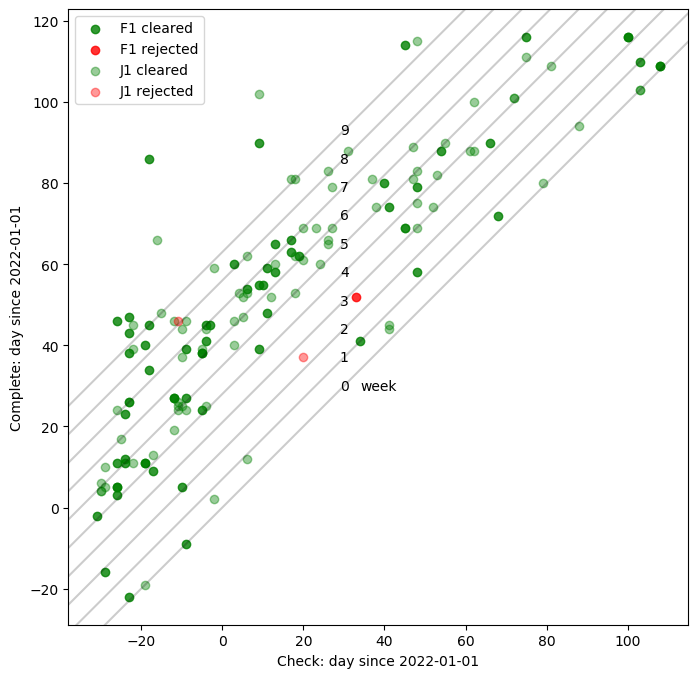

In [6]:
fig, ax = plt.subplots(figsize=(8,8))

for ig, group in enumerate(groups):
    
    subdata = data[(data['Visa Type']==group)&(data['Status']=='Clear')]
    x = [dt.days for dt in (pd.to_datetime(subdata['Check Date']) - ref_check_date)]
    y = [dt.days for dt in (pd.to_datetime(subdata['Complete Date']) - ref_check_date)]
    ax.scatter(x, y, c='green', alpha=alphas[ig], label=(group+' cleared'))
    
    subdata = data[(data['Visa Type']==group)&(data['Status']=='Reject')]
    x = [dt.days for dt in (pd.to_datetime(subdata['Check Date']) - ref_check_date)]
    y = [dt.days for dt in (pd.to_datetime(subdata['Complete Date']) - ref_check_date)]
    ax.scatter(x, y, c='red', alpha=alphas[ig], label=(group+' rejected'))
    
ax.set(aspect=1)
ax.set(xlabel=('Check: day since '+ref_check_date.strftime('%Y-%m-%d')),
       ylabel=('Complete: day since '+ref_check_date.strftime('%Y-%m-%d')))

xlim, ylim = ax.get_xlim(), ax.get_ylim()

x = np.linspace((start_date-ref_check_date).days-10, (end_date-ref_check_date).days, 100)
text_delta = (start_date-ref_check_date).days + 60
for delta_week in range(10):
    ax.plot(x, x+delta_week*7, 'k', alpha=0.2)
    ax.text(text_delta, text_delta+delta_week*7, str(delta_week))
ax.text(text_delta+5, text_delta, 'week')
    
ax.set(xlim=xlim, ylim=ylim)

ax.legend();

In [7]:
data[data['ID']=='Tian26']

,ID,Visa Type,Visa Entry,US Consulate,Major,Status,Check Date,Complete Date,Waiting Day(s)
50,Tian26,F1,Renewal,Others,Physics,Clear,2021-12-13,2022-02-10,59
